In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from torchsummary import summary

##Normalizing the pictures

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((56, 56))])

In [9]:
#Loading the data
wholeData = torchvision.datasets.ImageFolder("/content/drive/MyDrive/DirtyRoomNotifier_Data/Data", transform=transform)
classes = ('0','1') 
# Clean = 0, Not clean = 1

In [10]:
wholeImages = []
for i in range(len(wholeData)):
  wholeImages = wholeImages + [wholeData[i][0]]
wholeImages = torch.stack(wholeImages)


In [11]:
color1 = wholeImages[:,0,:,:]
color2 = wholeImages[:,1,:,:]
color3 = wholeImages[:,2,:,:]

color1_mean = color1.mean()
print("color1 mean is:",color1_mean)
color2_mean = color2.mean()
print("color2 mean is:",color2_mean)
color3_mean = color3.mean()
print("color1 mean is:",color3_mean)

color1_std = color1.std()
print("color1 std is:",color1_std)
color2_std = color2.std()
print("color2 std is:",color2_std)
color3_std = color3.std()
print("color1 std is:",color3_std)

mean = [color1_mean,color2_mean,color3_mean]
std = [color1_std,color2_std,color3_std]

color1 mean is: tensor(0.5212)
color2 mean is: tensor(0.4891)
color1 mean is: tensor(0.4484)
color1 std is: tensor(0.2280)
color2 std is: tensor(0.2271)
color1 std is: tensor(0.2336)


In [12]:
transform_img = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((56, 56)),
     transforms.Normalize(mean,std)])

In [13]:
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/DirtyRoomNotifier_Data/Data", transform=transform_img)
classes = ('0','1') 

In [14]:
img = []
label = []
for i in range(len(dataset)):
  img = img + [dataset[i][0]]
  label= label + [torch.tensor(dataset[i][1])]

images = torch.stack(img)
label = torch.stack(label)

In [46]:
#Spliting to test, Validation, and training set
tvd, testd, tvl, testl = train_test_split(images, label, test_size = 0.1, random_state = 0)
td, vd, tl, vl = train_test_split(tvd, tvl, test_size = 0.2, random_state = 0)

In [47]:
#testing if the data has been normalized
col1 = td[:,0,:,:]
print("mean of channel 1 is:", col1.mean().item())
print("the std of channel 1 is:", col1.std().item())

col2 = td[:,1,:,:]
print("mean of channel 2 is:",col2.mean().item())
print("the std of channel 2 is:",col2.std().item())

col3 = td[:,2,:,:]
print("mean of channel 3 is:",col3.mean().item())
print("the std of channel 3 is:",col3.std().item())

#since the means are 0 and the stds are 1, we can conlude that the photos have 
#been normalized

mean of channel 1 is: 0.0006493567489087582
the std of channel 1 is: 1.004882574081421
mean of channel 2 is: 0.0015121728647500277
the std of channel 2 is: 1.0062392950057983
mean of channel 3 is: 0.0017199161229655147
the std of channel 3 is: 1.0079920291900635


## Hyperparameter Search 

In [48]:
import torch.utils.data as data

class Room(data.Dataset):

    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return(len(self.X))

    def __getitem__(self,index):
        img = self.X[index]
        label = self.y[index]
        return img,label

In [49]:
def load_data(batch):
  tds = Room(td, tl)
  vds = Room(vd, vl)
  testds = Room(testd, testl)
  trLoader = DataLoader(tds,batch_size=batch,shuffle=True)
  vaLoader = DataLoader(vds,batch_size=batch,shuffle=True)
  testLoader = DataLoader(testds,batch_size=batch,shuffle=True)
  return trLoader, vaLoader, testLoader

In [50]:
def correct(predict,labels):
  corr = 0
  predict = predict.detach().numpy()
  labels = labels.detach().numpy()  

  for i in range(0,len(predict)):
    if predict[i] >= 0.5 and labels[i] == 1:
      corr += 1 
    elif predict[i] < 0.5 and labels[i] == 0:
      corr += 1
  return corr

In [137]:
def evaluate(model, vaLoader):
  corr = 0
  tot_loss = 0
  tempo_loss = []
  acc = 0
  accRec = []
  for vaData, vaLabel in vaLoader:
    predicts = model(vaData)
    loss = loss_func(input = predicts.squeeze(), target = vaLabel.float())
    tempo_loss.append(loss.item())
    for i in range(0, len(predicts)):
      if predicts[i] >= 0.5 and vaLabel[i] == 1:
        corr += 1
      elif predicts[i] < 0.5 and vaLabel[i] == 0:
        corr += 1
    accRec.append(corr/len(predicts))
    corr = 0    
  acc = sum(accRec)/len(accRec)
  tot_loss = sum(tempo_loss)/len(tempo_loss)
  return acc, tot_loss

    


### Trial 1: 2 conco layer / 10 kernels / 32 neurons / 0.1 Lr / 4 Batch


In [75]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.con1 = nn.Conv2d(3, 10, 3)
    self.pool1 = nn.MaxPool2d(2,2, padding=1)
    self.con2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(13*13*10,32)
    self.fc2 = nn.Linear(32, 1)
  def forward(self,x):
    x = self.pool1(F.relu(self.con1(x)))
    x = self.pool2(F.relu(self.con2(x)))
    x = x.view(-1, 10*13*13)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x


In [145]:
epoch = 1000
lr = 0.01
batch = 10
seed = 10

model = Net()
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [146]:
start = time.time()

trLoader, vaLoader, testLoader = load_data(batch)

#Graph
acc = []
validation_acc = []
validation_loss = []
loss_rec = []
steps = []
step = 0
accuracy = 0

#Epoch
for n in range(0, epoch):
  corr = 0 
  for trdata, trLabel in trLoader:

    optimizer.zero_grad()
    predicts = model(trdata)
    loss = loss_func(input = predicts.squeeze(), target = trLabel.float())
    loss.backward()
    optimizer.step()

    corr = correct(predicts, trLabel)
    accuracy = corr / len(predicts)

    if step % 100 == 0:
      acc.append(accuracy)
      loss_rec.append(loss.item())
      model.eval()
      val_acc, val_loss = evaluate(model, vaLoader)
      validation_acc.append(val_acc)
      validation_loss.append(val_loss)
      model.train()
      steps.append(step)
    step += 1
stop = time.time()
print(stop-start)

389.44041991233826


Text(0, 0.5, 'Accuracy')

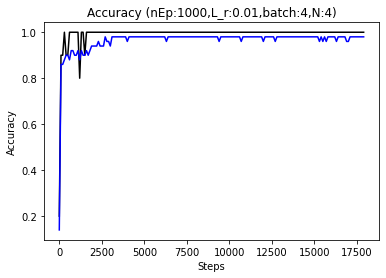

In [147]:
plt.plot(steps,acc,color = 'black')
plt.plot(steps, validation_acc,color = 'blue')
plt.title('Accuracy (nEp:{},L_r:{},batch:{},N:{})'.format(epoch,lr,4,4))
plt.xlabel('Steps')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

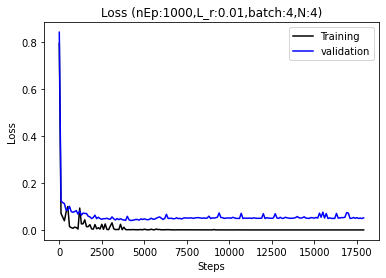

In [149]:
plt.plot(steps,loss_rec,color = 'black')
plt.plot(steps, validation_loss,color = 'blue')
plt.legend(['Training', 'validation'])
plt.title('Loss (nEp:{},L_r:{},batch:{},N:{})'.format(epoch,lr,4,4))
plt.xlabel('Steps')
plt.ylabel('Loss')

In [150]:
torch.save(model,'baseline.pt2')

In [163]:
test_acc, test_loss = evaluate(model,testLoader)
print('The accuracy of the test data set is:',test_acc)
print('The loss of the test data set is:',test_loss)

The accuracy of the test data set is: 0.9666666666666667
The loss of the test data set is: 0.06483642632762592
